# Projet CNN : Qui a peint ce tableau ?

## 1) Chargement des librairies

In [14]:
import os, sys, math

import numpy as np
import random as rd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow import keras

from collections import Counter, defaultdict

from skimage.transform import resize

## 2) Chargement des données

In [17]:
# Chemin des données
chemin = os.getcwd()
chemin = os.path.join(chemin, "art-challenge", "images_lq")

# Mise en forme de data
data = []
for fichier in os.listdir(chemin):
    artiste = '_'.join(fichier.split('_')[:-1])
    image = plt.imread(os.path.join(chemin, fichier))
    data.append([image, artiste])

In [18]:
# Conversion des images en RGB
data_rgb = []
for image, artiste in data:
        # L'image est en niveaux de gris
        if len(image.shape) == 2:
            image_rgb = np.stack((image,) * 3, axis = -1)
        # L'image est déjà en RGB
        else:
            image_rgb = image
        data_rgb.append([image_rgb, artiste])

In [20]:
print("Dimensions avant transformation : ", data[0][0].shape)
print("Dimensions après transformation : ", data_rgb[0][0].shape)

Dimensions avant transformation :  (614, 432)
Dimensions après transformation :  (614, 432, 3)


In [ ]:
# a nettoyer

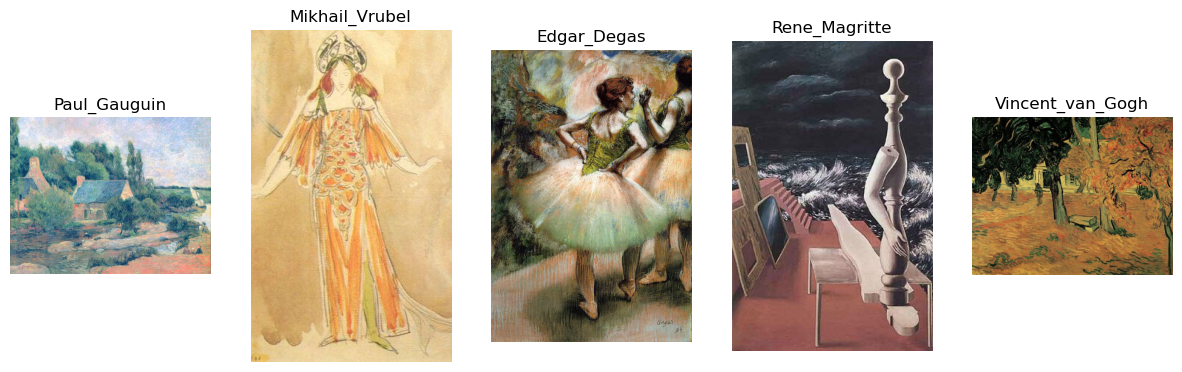

In [28]:
def afficher_images_aleatoires(data, nombre_images=5):
    """
    Affiche un certain nombre d'images aléatoires avec leurs labels.

    Args:
    - data: Liste contenant des paires [image, artiste].
    - nombre_images: Nombre d'images à afficher (par défaut 5).
    """
    # Sélectionner des échantillons aléatoires dans la liste data
    images_aleatoires = rd.sample(data, nombre_images)

    # Créer une figure avec une taille adaptée
    plt.figure(figsize=(15, 5))

    for i, (img, artiste) in enumerate(images_aleatoires):
        # Créer un sous-plot pour chaque image
        
        plt.subplot(1, nombre_images, i + 1)
        plt.imshow(img)
        plt.title(artiste)
        plt.axis('off')  # Masquer les axes

    # Afficher les images
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
afficher_images_aleatoires(data_rgb)

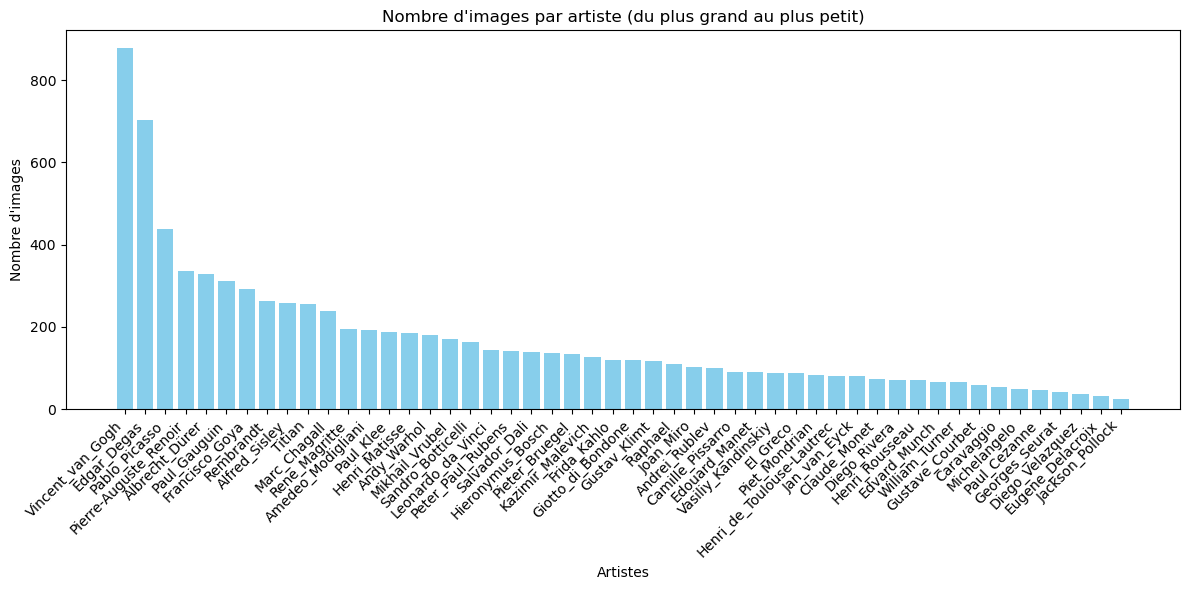

In [9]:
def histogramme_images_par_artiste(data):
    """
    Affiche un histogramme du nombre d'images par artiste, trié du plus grand au plus petit.

    Args:
    - data: Liste contenant des paires [image, artiste].
    """
    # Extraire la liste des artistes à partir de la liste de données
    artistes = [artiste for _, artiste in data]

    # Compter le nombre d'images pour chaque artiste
    compte_artistes = Counter(artistes)

    # Trier les artistes par nombre d'images, du plus grand au plus petit
    artistes_tries = sorted(compte_artistes.items(), key=lambda x: x[1], reverse=True)
    noms_artistes = [artiste for artiste, _ in artistes_tries]
    nombre_images = [nb_images for _, nb_images in artistes_tries]

    # Créer l'histogramme
    plt.figure(figsize=(12, 6))
    plt.bar(noms_artistes, nombre_images, color='skyblue')

    # Rotation des labels pour une meilleure lisibilité
    plt.xticks(rotation=45, ha='right')

    # Ajouter les labels et le titre
    plt.xlabel('Artistes')
    plt.ylabel('Nombre d\'images')
    plt.title('Nombre d\'images par artiste (du plus grand au plus petit)')

    # Afficher l'histogramme
    plt.tight_layout()  # Pour ajuster l'espacement et éviter les chevauchements
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
histogramme_images_par_artiste(data)

Désiquilibré : data augmentation sur les plus petits ? ou enlever quand y en a trop

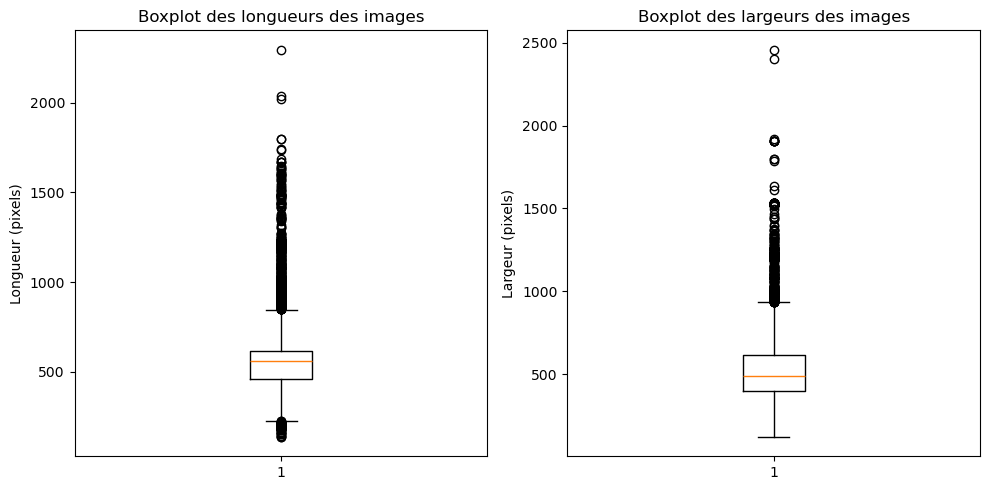

In [10]:
def boxplot_dimensions_images(data):
    """
    Affiche un boxplot des longueurs et des largeurs des images dans le dataset.

    Args:
    - data: Liste contenant des paires [image, artiste].
    """
    # Extraire les longueurs et largeurs des images
    longueurs = [img.shape[0] for img, _ in data]  # Hauteur des images
    largeurs = [img.shape[1] for img, _ in data]   # Largeur des images

    # Créer un boxplot pour les longueurs
    plt.figure(figsize=(10, 5))

    # Boxplot pour les longueurs
    plt.subplot(1, 2, 1)
    plt.boxplot(longueurs)
    plt.title('Boxplot des longueurs des images')
    plt.ylabel('Longueur (pixels)')

    # Boxplot pour les largeurs
    plt.subplot(1, 2, 2)
    plt.boxplot(largeurs)
    plt.title('Boxplot des largeurs des images')
    plt.ylabel('Largeur (pixels)')

    # Afficher les boxplots
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
boxplot_dimensions_images(data)


On va resize toutes les images en 512*512 (*3) A recheck après enlever des artistes.

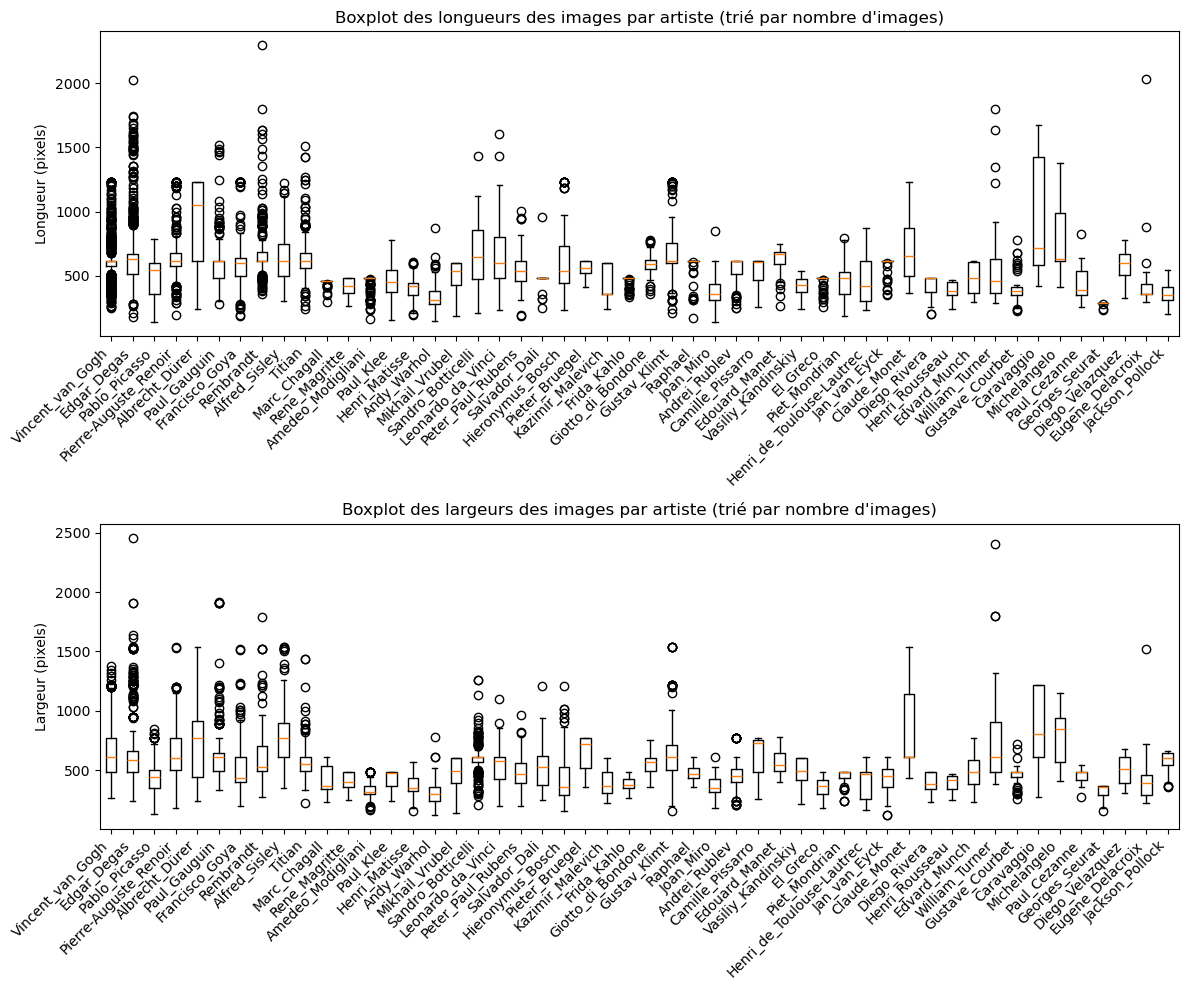

In [11]:
def boxplot_dimensions_par_artiste(data):
    """
    Affiche des boxplots des longueurs et largeurs des images pour chaque artiste, 
    trié par ordre décroissant du nombre d'images.

    Args:
    - data: Liste contenant des paires [image, artiste].
    """
    # Initialiser des dictionnaires pour stocker les longueurs et largeurs par artiste
    longueurs_par_artiste = defaultdict(list)
    largeurs_par_artiste = defaultdict(list)

    # Parcourir les données pour remplir les longueurs et largeurs par artiste
    for img, artiste in data:
        longueurs_par_artiste[artiste].append(img.shape[0])  # Hauteur des images
        largeurs_par_artiste[artiste].append(img.shape[1])   # Largeur des images

    # Compter le nombre d'images pour chaque artiste
    compte_artistes = Counter([artiste for _, artiste in data])

    # Trier les artistes par nombre d'images, du plus grand au plus petit
    artistes_tries = sorted(compte_artistes.items(), key=lambda x: x[1], reverse=True)
    artistes = [artiste for artiste, _ in artistes_tries]

    # Récupérer les longueurs et largeurs triées par artiste
    longueurs = [longueurs_par_artiste[artiste] for artiste in artistes]
    largeurs = [largeurs_par_artiste[artiste] for artiste in artistes]

    # Créer une figure plus grande et étalée
    plt.figure(figsize=(12, 10))  # Augmenter la taille verticale

    # Boxplot pour les longueurs par artiste (en haut)
    plt.subplot(2, 1, 1)  # 2 lignes, 1 colonne, 1er subplot
    plt.boxplot(longueurs, labels=artistes)
    plt.xticks(rotation=45, ha='right')
    plt.title('Boxplot des longueurs des images par artiste (trié par nombre d\'images)')
    plt.ylabel('Longueur (pixels)')

    # Boxplot pour les largeurs par artiste (en bas)
    plt.subplot(2, 1, 2)  # 2 lignes, 1 colonne, 2e subplot
    plt.boxplot(largeurs, labels=artistes)
    plt.xticks(rotation=45, ha='right')
    plt.title('Boxplot des largeurs des images par artiste (trié par nombre d\'images)')
    plt.ylabel('Largeur (pixels)')

    # Ajuster la disposition et afficher
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
boxplot_dimensions_par_artiste(data)

In [ ]:

def redimensionner_images(data, nouvelle_taille=(512, 512, 3)):
    """
    Redimensionne les images dans le dataset à une nouvelle taille.

    Args:
    - data: Liste contenant des paires [image, artiste].
    - nouvelle_taille: Tuple représentant la nouvelle taille (hauteur, largeur, canaux).
    
    Returns:
    - data_redimensionne: Liste contenant des paires [image redimensionnée, artiste].
    """
    data_redimensionne = []
    for img, artiste in data:
        img_redim = resize(img, nouvelle_taille, anti_aliasing=True)
        data_redimensionne.append([img_redim, artiste])
    
    return data_redimensionne

def afficher_images_aleatoires_avant_apres(data, data_redimensionne, nombre_images=5):
    """
    Affiche 5 images aléatoires avant et après redimensionnement avec leurs labels.

    Args:
    - data: Liste d'images originales et leurs labels.
    - data_redimensionne: Liste d'images redimensionnées et leurs labels.
    - nombre_images: Nombre d'images à afficher.
    """
    # Sélectionner des échantillons aléatoires dans la liste data
    indices_aleatoires = random.sample(range(len(data)), nombre_images)

    plt.figure(figsize=(15, 10))

    for i, idx in enumerate(indices_aleatoires):
        # Image et artiste avant redimensionnement
        img_originale, artiste = data[idx]
        # Image après redimensionnement
        img_redim, _ = data_redimensionne[idx]

        # Afficher l'image originale
        plt.subplot(2, nombre_images, i + 1)
        plt.imshow(img_originale)
        plt.title(f'Originale: {artiste}')
        plt.axis('off')

        # Afficher l'image redimensionnée
        plt.subplot(2, nombre_images, i + 1 + nombre_images)
        plt.imshow(img_redim)
        plt.title(f'Redimensionnée: {artiste}')
        plt.axis('off')

    # Afficher les images
    plt.tight_layout()
    plt.show()

# Exemple d'utilisation (après avoir chargé les données dans "data")
data_redimensionne = redimensionner_images(data)
afficher_images_aleatoires_avant_apres(data, data_redimensionne)
